In [476]:
import os
import math
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist
from mpl_toolkits.mplot3d import Axes3D
import soundfile as sf
from prettytable import PrettyTable
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import hilbert, butter, filtfilt, medfilt, lfilter, wiener, convolve
from prettytable import PrettyTable

In [477]:
fruit_types      = ['pera', 'banana', 'manzana', 'naranja']
audios           = {fruit: [] for fruit in fruit_types}
training_path    = '../../dataset/audios/training'
original_path    = os.path.join(training_path, 'original')
processed_path   = os.path.join(training_path, 'processed')
model_file       = 'model.pkl'
model            = dict.fromkeys(['pca', 'features', 'scaler'])

In [478]:
original = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(original_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        original[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [479]:
processed = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(processed_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        processed[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [480]:
FRAME_SIZE = 2048 # In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)

In [481]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

In [482]:
def time_vector(signal, duration):
    return np.linspace(0, duration, len(signal))

In [483]:
def rms(signal):
    return librosa.feature.rms(y=signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)

In [484]:
def normalize(signal):
    peak = np.max(signal)
    signal/=peak
    return signal

In [485]:
def derivative(signal, duration):
    signal = signal.reshape(-1,)
    dy = np.gradient(signal, np.linspace(0, duration, len(signal)))
    return dy

In [486]:
def low_pass_filter(signal, sr, cutoff_frequency = 5000):
    nyquist = 0.5 * sr
    cutoff = cutoff_frequency / nyquist
    b, a = butter(N=6, Wn=cutoff, btype='low', analog=False, output='ba')
    filtered = lfilter(b, a, signal)
    return filtered

In [487]:
def band_pass_filter(signal, sr, low_cutoff, high_cutoff):
    b, a = butter(N=3, Wn = [low_cutoff, high_cutoff], btype='band', fs=sr)
    return lfilter(b, a, signal)

In [488]:
#2d
def plot_features2d(features):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    

    for fruit, points in features.items():
        plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)

    plt.xlabel('Eje X')
    plt.ylabel('Eje Y')
    plt.show()

In [489]:
#3d
def plot_features3D(features:dict):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    ax = fig.add_subplot(111, projection='3d')
    for fruit, points in features.items():
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors[fruit], marker='o', label=fruit)
        #ax.scatter(centers[fruit][:, 0], centers[fruit][:, 1], centers[fruit][:, 2], c=center_colors[fruit], marker='o', label=f"{fruit}-center")

    # configure labels
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_zlabel('Eje Z')
    plt.show()

In [490]:
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [491]:
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / (sum_power_high_frequencies + sum_power_low_frequencies)
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

In [492]:
def envelope(signal, frame_size, hop_length):
    """Fancier Python code to calculate the amplitude envelope of a signal with a given frame size."""
    return np.array([max(signal[i:i+frame_size]) for i in range(0, len(signal), hop_length)])

In [493]:
def spectral_flux(signal):

    # Calcular el espectrograma de magnitudes
    spectrogram = np.abs(librosa.stft(signal, n_fft=FRAME_SIZE, hop_length=HOP_SIZE))

    # Calcular el flujo espectral
    spectral_flux_values = np.sum(np.diff(spectrogram, axis=1)**2, axis=0)

    return spectral_flux_values

C:\Users\Juan\AppData\Local\Temp\ipykernel_7620\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)
C:\Users\Juan\AppData\Local\Temp\ipykernel_7620\3751504528.py:13: RuntimeWarning: invalid value encountered in scalar divide
  band_energy_ratio_current_frame = sum_power_low_frequencies / (sum_power_high_frequencies + sum_power_low_frequencies)


naranja1.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| Field 1 | Field 2 | Field 3 | Field 4 | Field 5 | Field 6 | Field 7 | Field 8 | Field 9 | Field 10 | Field 11 | Field 12 | Field 13 | Field 14 | Field 15 | Field 16 | Field 17 | Field 18 | Field 19 | Field 20 | Field 21 | Field 22 | Field 23 | Field 24 | Field 25 | Field 26 | Field 27 | Field 28 | Field 29 | Field 30 | Field 31 | Field 32 | Field 33 | Field 34 | Field 35 | Field 36 | 

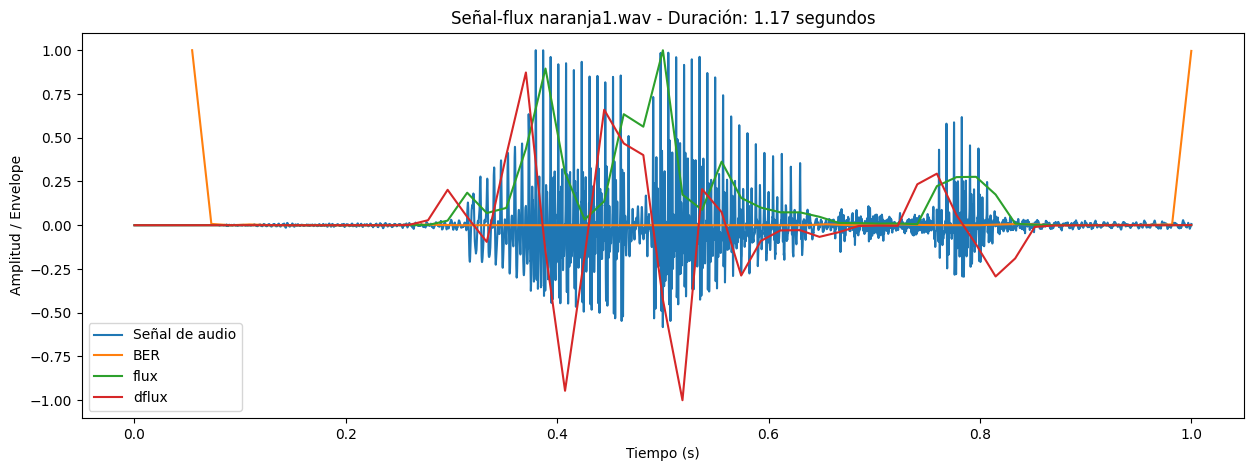

naranja10.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----

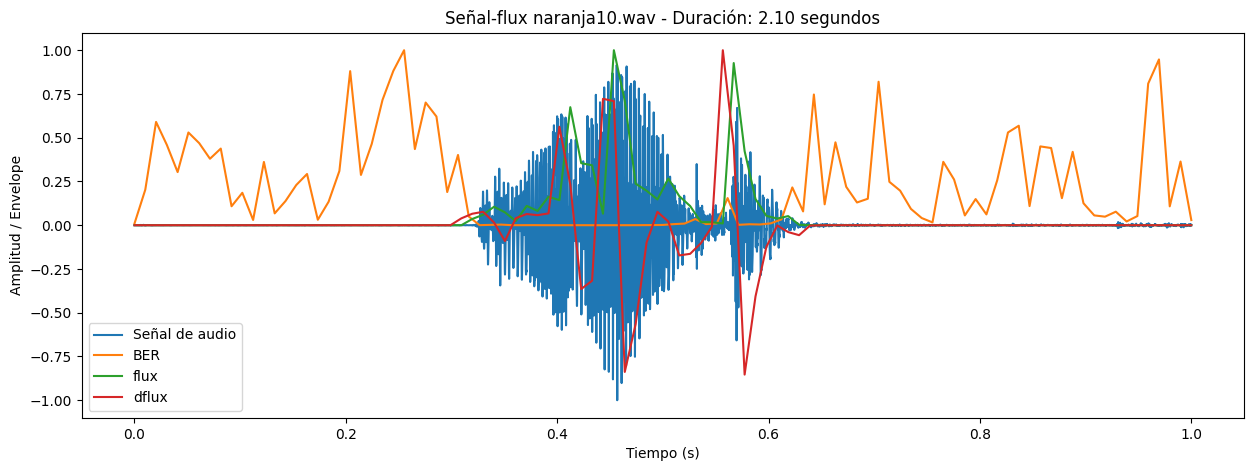

naranja11.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| Field 1 | Field 2 | Field 3 | Field 4 | Field 5 | Field 

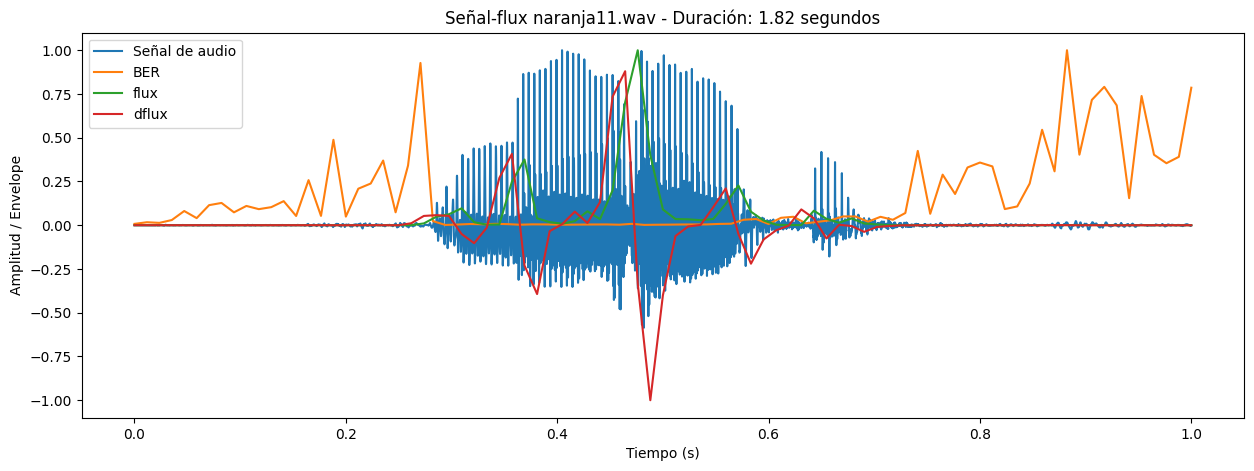

naranja12.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| Field 1 | Field 2 | Field 3 | Field 4 | Field 5 | Field 6 | Field 7 | Field 8 | Field 9 | Field 10 | Field 11 | Field 12 | Field 13 | Field 14 | Field 15 |

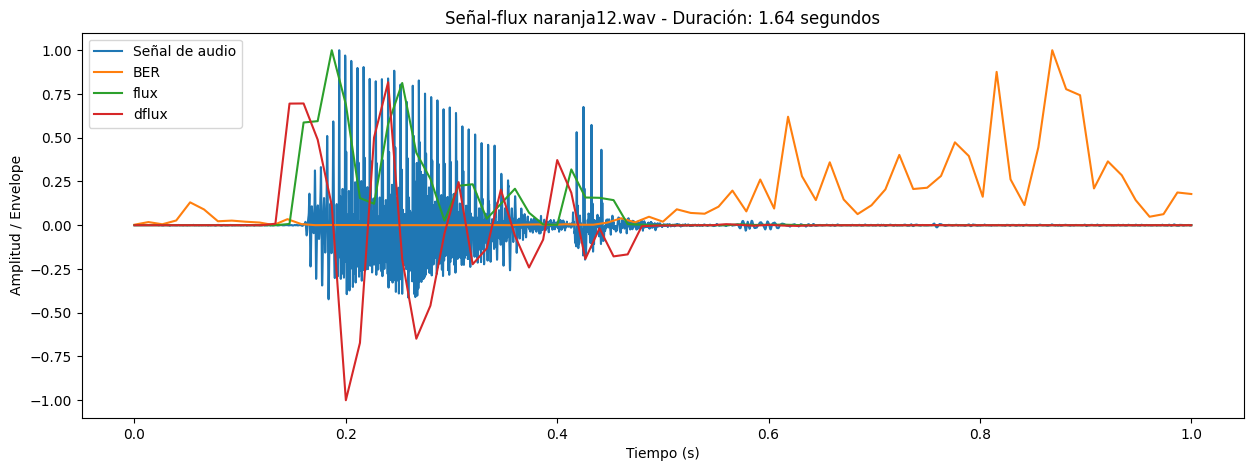

naranja13.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| Field 1 | Field 2 | Field 3 | Field 4 | Field 5 | Field 6 | Field 7 | Field 8 | Field 9 | Field 10 | Field 11 | Field 12 | Field 13 |

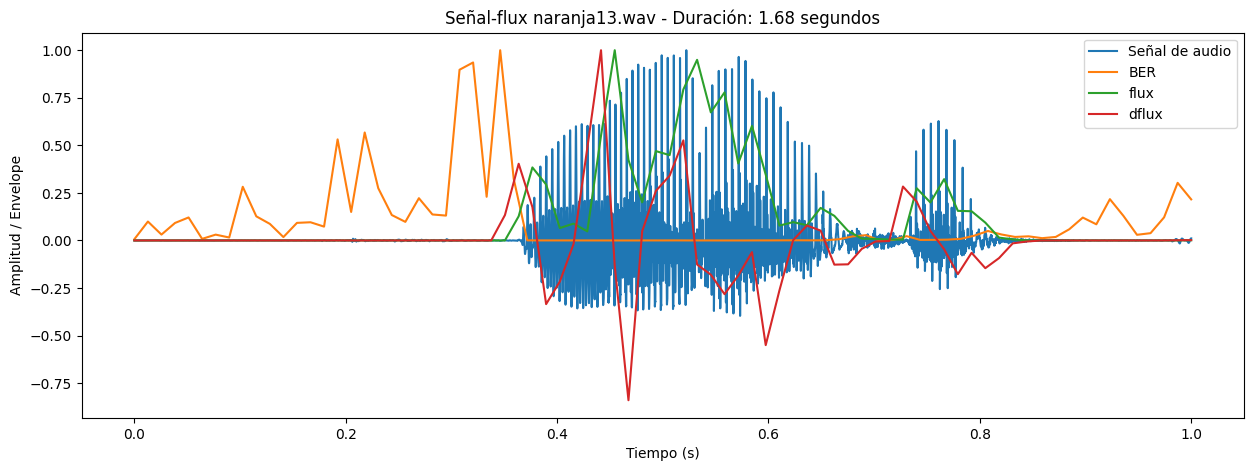

naranja14.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----

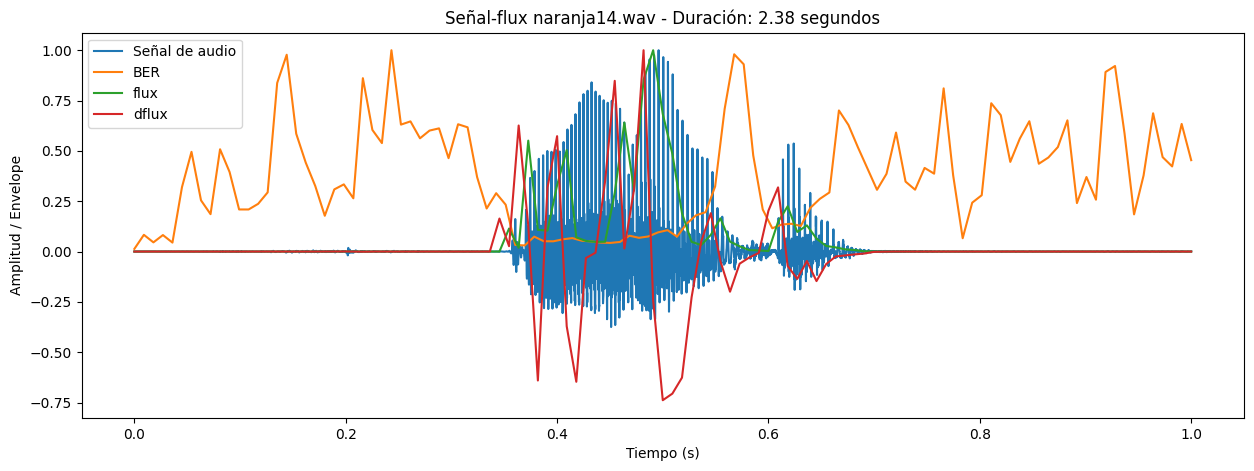

naranja15.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----

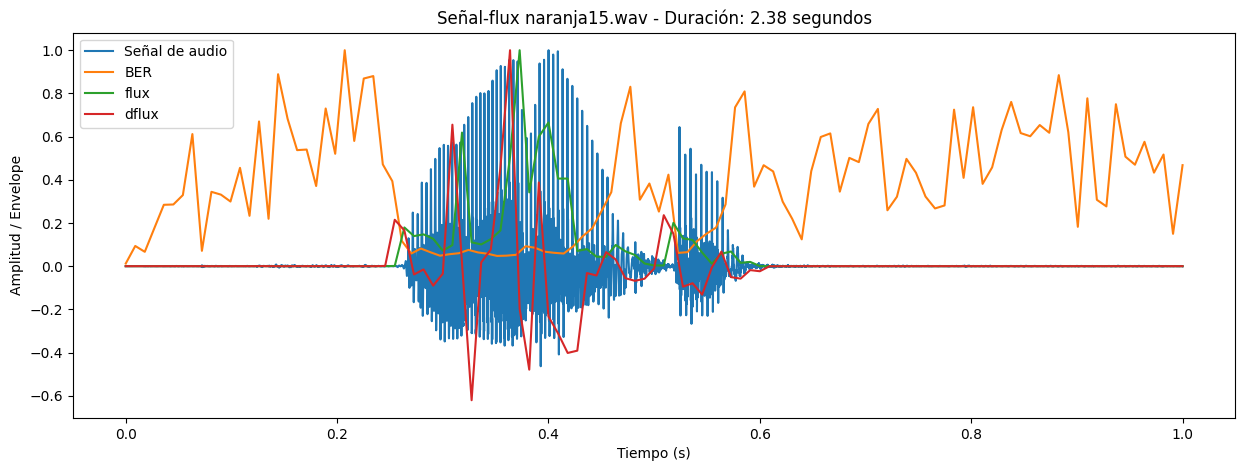

naranja16.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----

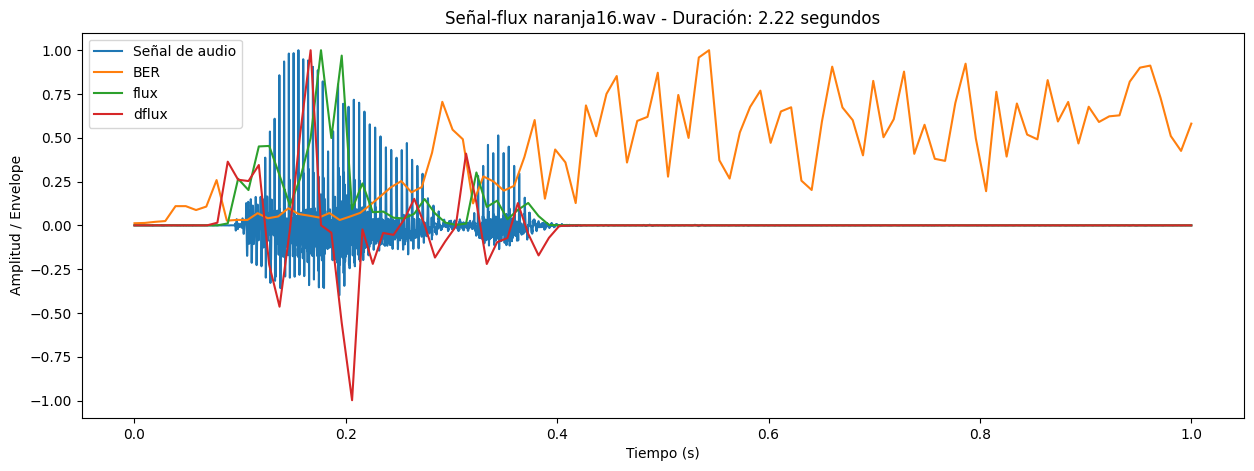

naranja17.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----

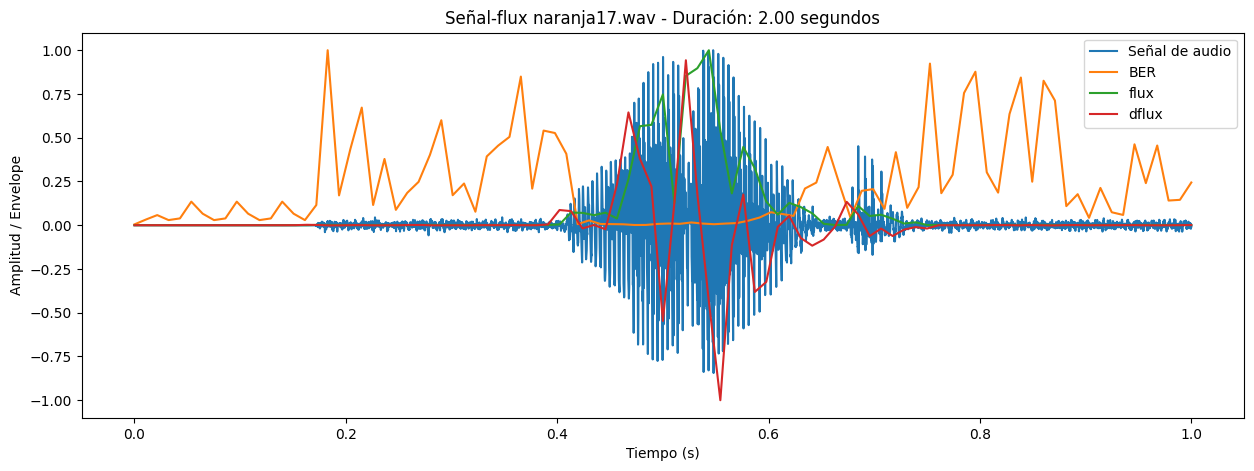

naranja18.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----

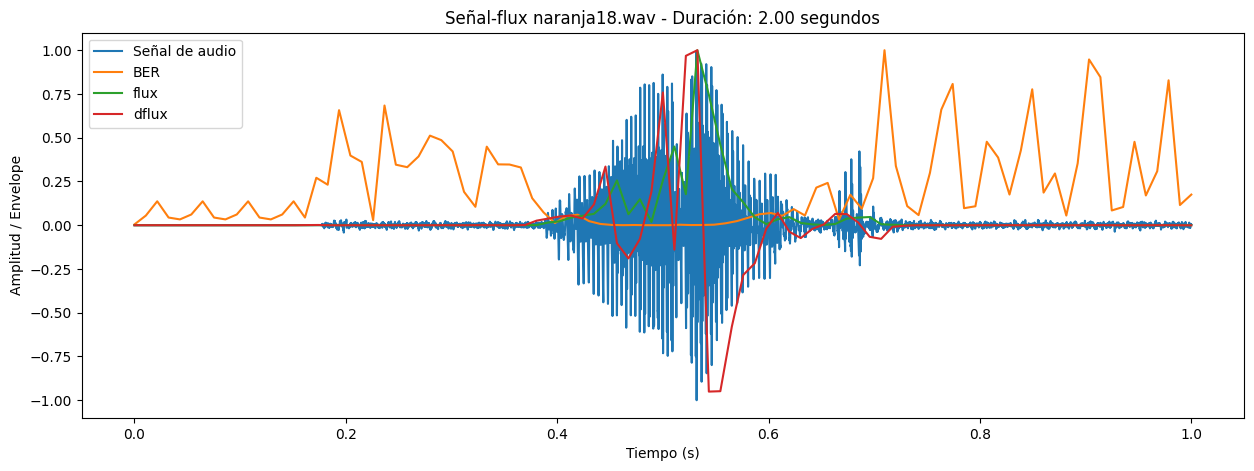

naranja19.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----

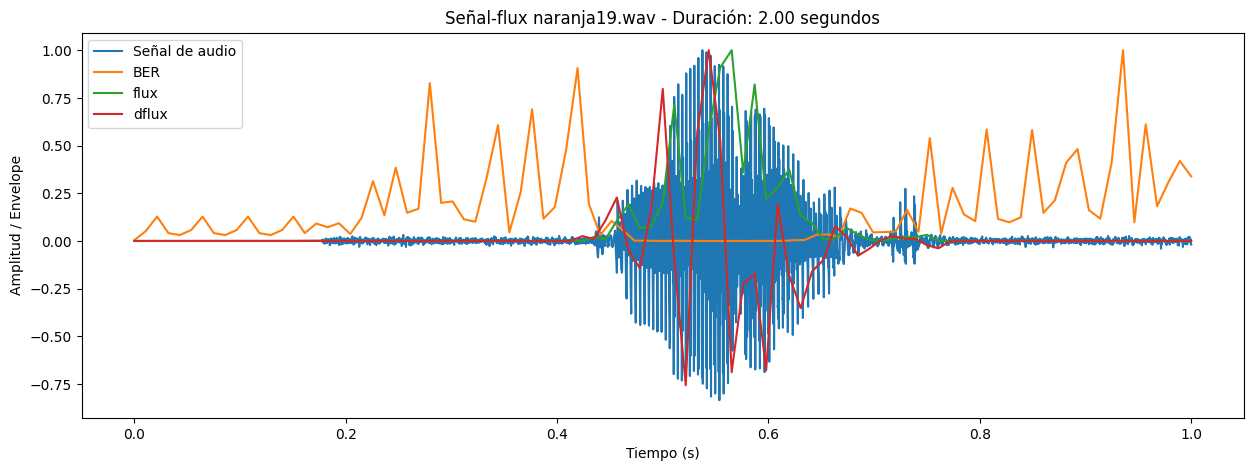

naranja2.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| Field 1 | Field 2 | Field 3 | Field 4 | Field 5 | Field 6 | Field 7 | Field 8 | Field 9 | Field 10 | Field 11 | Field 12 | Field 13 | Field 14 | Field 15 | Field 16 | Field 17 | Field 18 | Field 19 | Field 20 | Field 21 | Field 22 | Field 23 | Field 24 | Field 25 | Field 26 | Field 27 | Field 28 | Field 29 | 

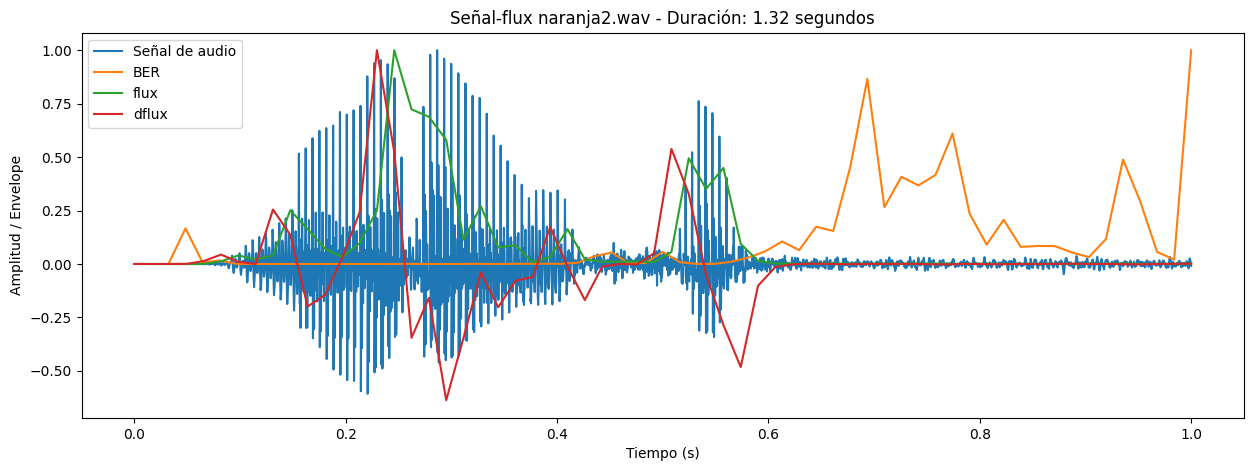

naranja20.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----

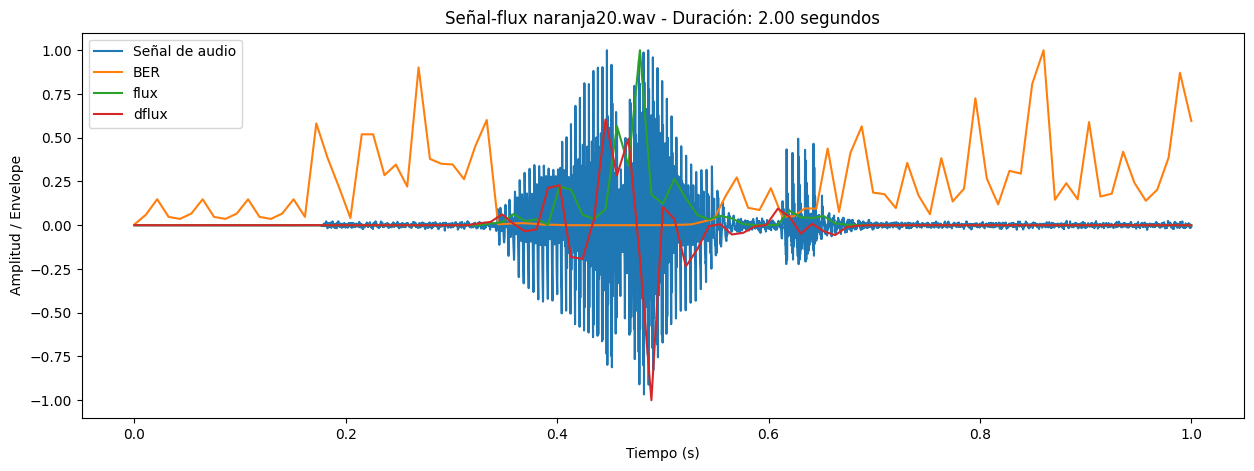

naranja21.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----

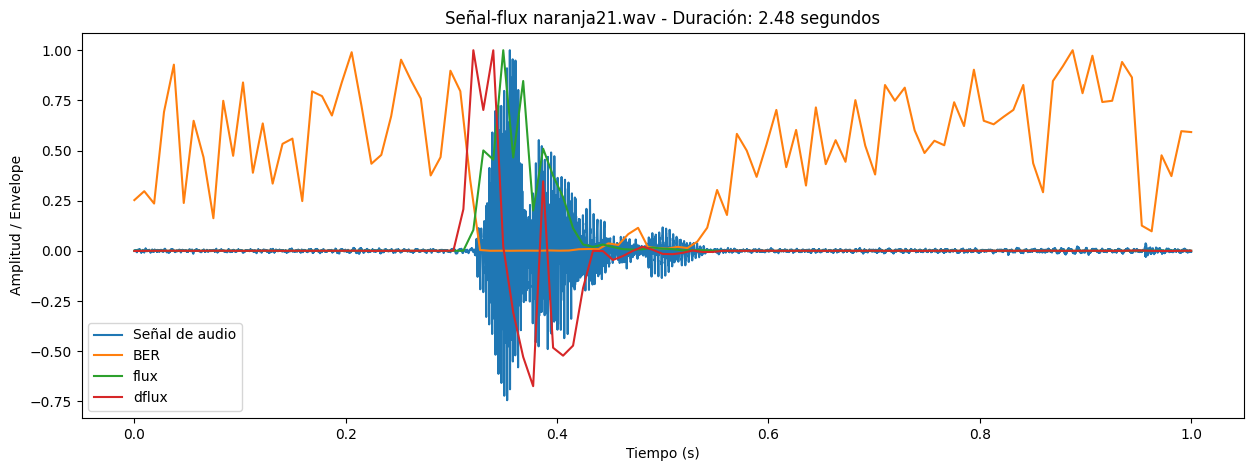

naranja3.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| Field 1 | Field 2 | Field 3 | Field 4 | Field 5 | Field 6 | Field 7 | Field 8 | Field 9 | Field 10 | Field 11 | Field 12 | Field 13 | Field 14 | Field 15 | Field 16 | Field 17 | Field 18 | Field 19 | Field 20 | Field 21 | Field 22 | Field 23 | Field 24 | Field 25 | Field 26 | Field 27 | Field 28 | Field 29 | Field 30 | 

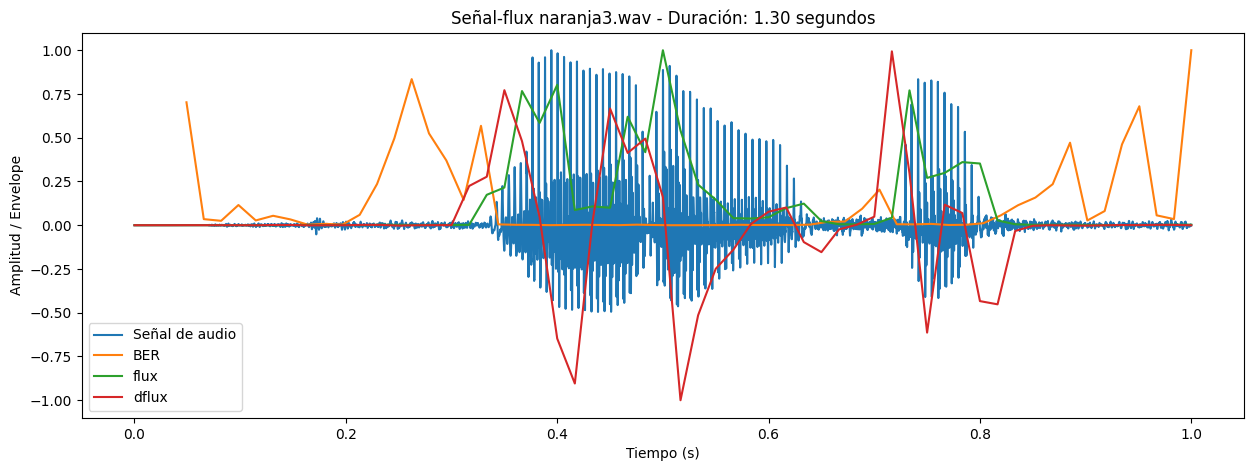

naranja4.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| Field 1 | Field 2 | Field 3 | Field 4 | Field 5 | Field 6 | Field 7 | Field 8 | Field 9 | Field 10 | Field 11 | Field 12 | Field 13 | Field 14 | Field 15 | Field 16 | Field 17 | Field 18 | Field 19 | Field 20 | Field 21 | Field 22 | Field 23 | Field 24 | Field 25 | Field 26 | Field 27 | Field 28 | Field 29 | Field 30 | Field 31 | Field 32 | Field 33 | 

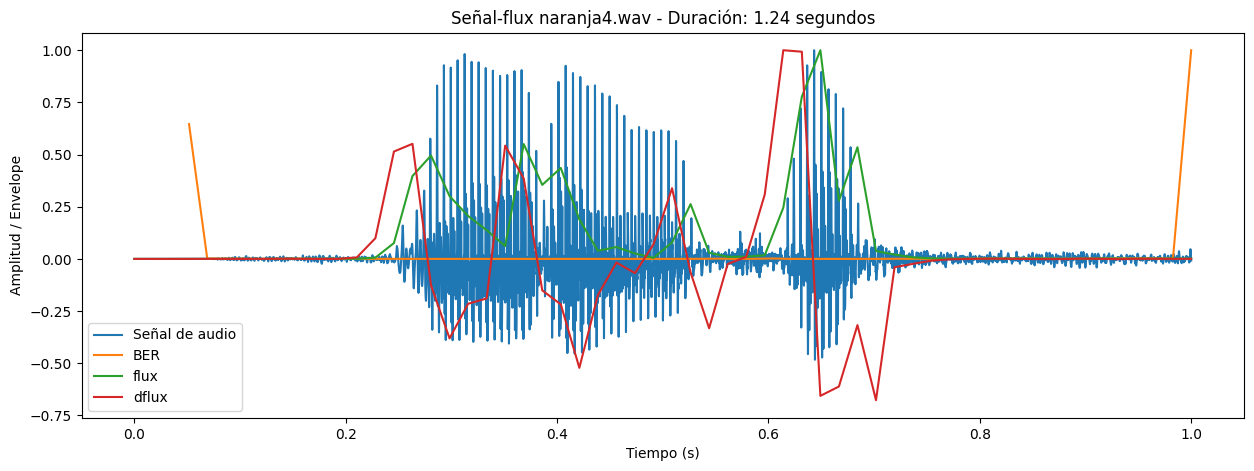

naranja5.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| Field 1 | Field 2 | Field 3 | Field 4 | Field 5 | Field 6 | Field 7 | Field 8 | Field 9 | Field 10 | Field 11 | Field 12 | Field 13 | Field 14 | Field 15 | Field 16 | Field 17 | Field 18 | Field 19 | Field 20 | Field 21 | Field 22 | Field 23 | Field 24 | Field 25 | Field 26 | Field 27 | Field 28 | 

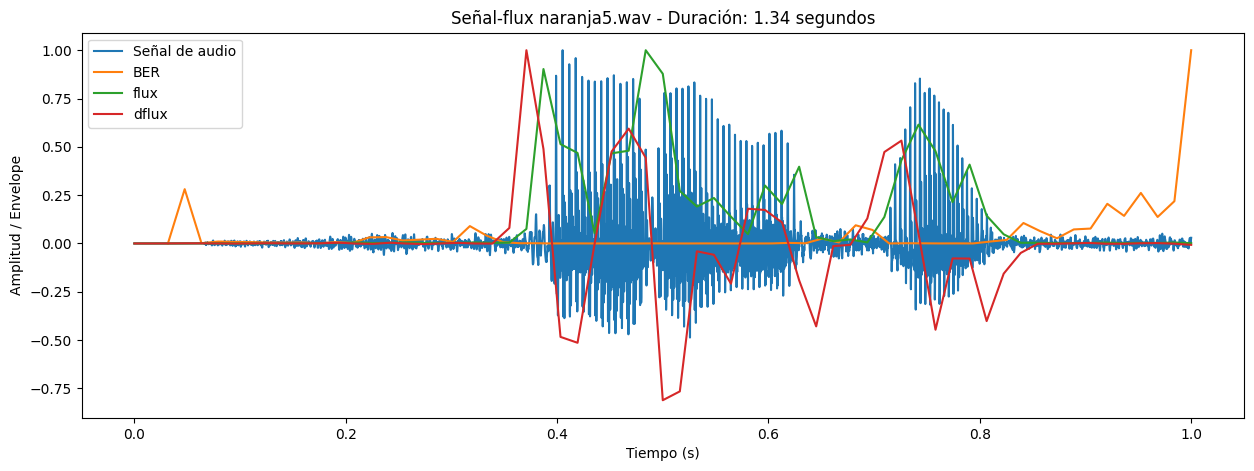

naranja6.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| Field 1 | Field 2 | Field 3 | Field 4 | Field 5 | Field 6 | Field 7 | Field 8 | Field 9 | Field 10 | Field 11 | Field 12 | Field 13 | Field 14 | Field 15 | Field 16 | Field 17 | Field 18 | Field 19 | Field 20 | Field 21 | Field 22 | Field 23 | Field 24 | Field 25 | Field 26 | Field 27 | Field 28 | Field 29 | Field 30 | Field 31 | Field 32 | Field 33 | Field 34 | Field 35 | Field 36 | Field 37 | Field 38 | Field 39 | 

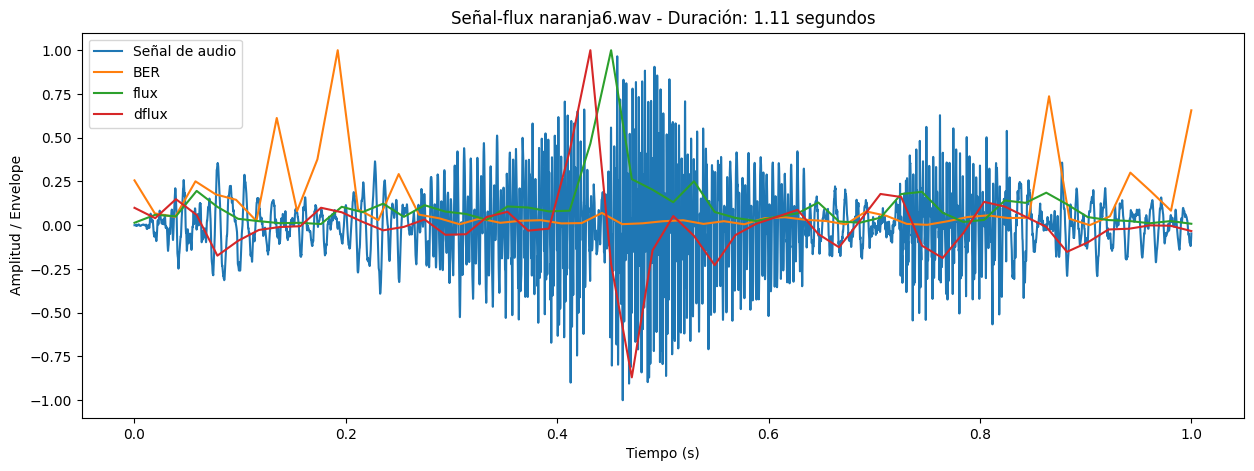

naranja7.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----

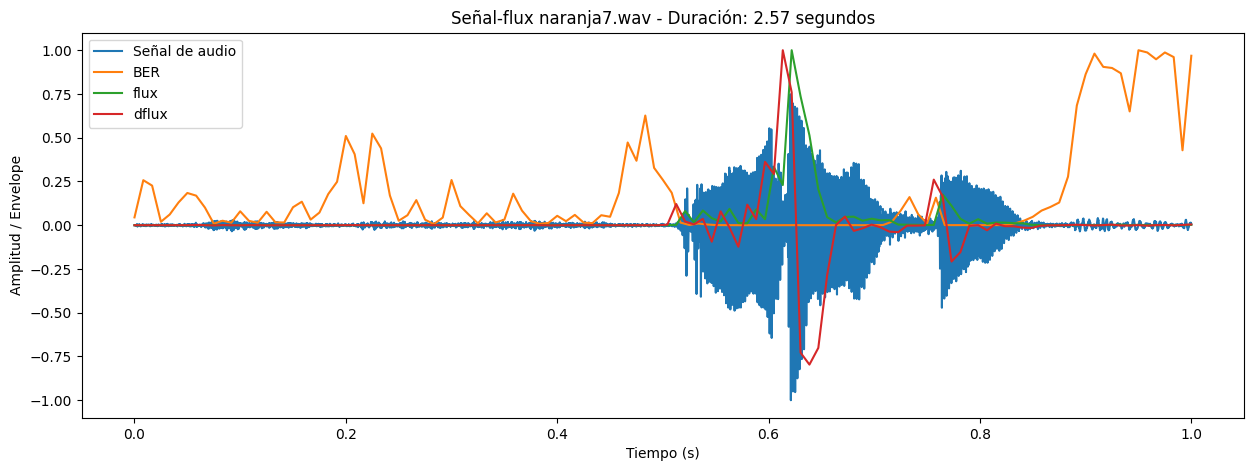

naranja8.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| Field 1 | Field 2 | Field 3 | Field 4 | Field 5 | Field 6 | Field 7 | Field 8 | Field 9 | Field 10 | Field 11 | Field 12 | Field 13 | Field 14 | Field 15 | Field 16 | Field 17 | Field 18 | Field 19 | Field 20 | Field 21 | Field 22 | Field 23 | Field 24 | Field 25 | Field 26 | Field 27 | 

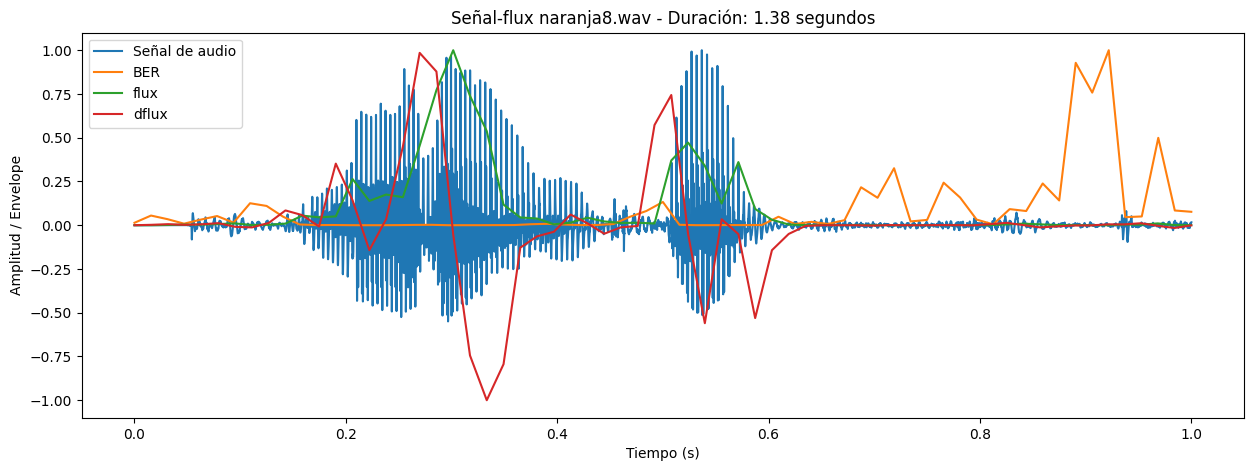

naranja9.wav
+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| Field 1 | Field 2 | Field 3 | Field 4 | Field 5 | Field 6 | Field 7 | Field 8 | Field 9 | Field 10 | Field 11 | Field 12 | Field 13 | Field 14 | Field 15 | 

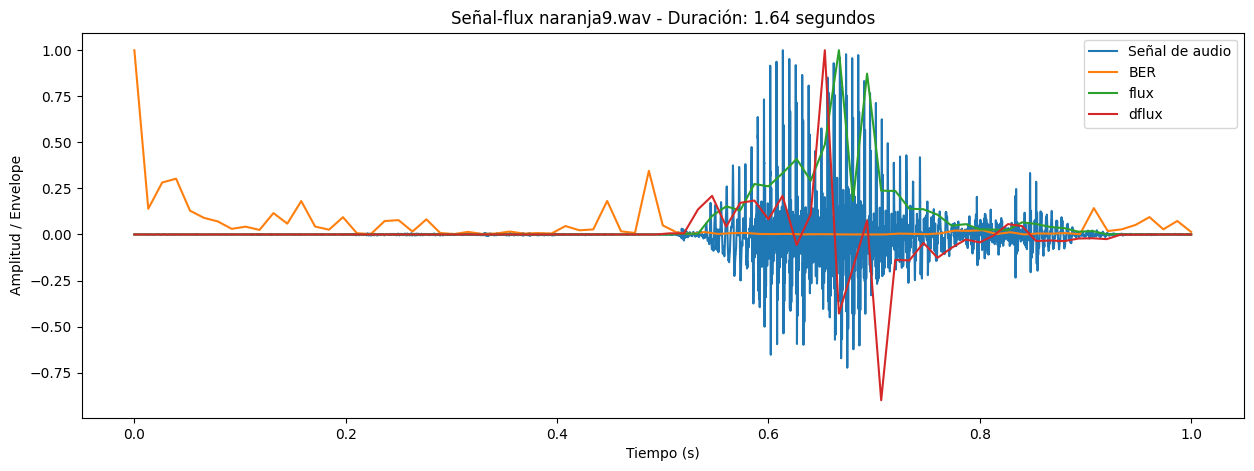

In [494]:
# Extracción de características
fruit = 'naranja'
split_frequency = 1200
for audio in original[fruit]:
        signal, sr, duration = load_audio(audio)
        signal = band_pass_filter(signal, sr, 50, 1200)
        env = envelope(signal, FRAME_SIZE, HOP_SIZE)
        env /= np.max(env)
        envframes = range(len(env))
        
        #flux = np.mean(flux)
        #roll_off = librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.85)[0]
        #max = np.max(roll_off)
        #roll_off /= max
        #roll_off = np.mean(roll_off)
        spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        BER  = band_energy_ratio(spec, split_frequency, sr)
        BER /= np.nanmax(BER)
        BERframes = range(len(BER))
        tBER = librosa.frames_to_time(BERframes, hop_length=HOP_SIZE)
        tBER /= tBER[-1]

        tenv = librosa.frames_to_time(envframes, hop_length=HOP_SIZE)
        tenv /= tenv[-1]

        flux = spectral_flux(signal)
        flux /= np.max(np.abs(flux))

        fluxframes = range(len(flux))
        tflux = librosa.frames_to_time(fluxframes, hop_length=HOP_SIZE)
        tflux/=tflux[-1]

        #dflux = derivative(flux, duration)
        #dflux/=np.max(np.abs(dflux))
        #dfluxframes = range(len(dflux))
        #dtflux = librosa.frames_to_time(dfluxframes, hop_length=HOP_SIZE)
        #dtflux/=dtflux[-1]

        tsignal = time_vector(signal, duration)
        denv = derivative(env, duration)
        denv /= np.max(np.abs(denv))

        print(os.path.basename(audio))
        table = PrettyTable()
        table.add_row(list(flux*100))
        table.add_row(list(tflux*100))
        table.float_format =  '.2'

        print(table)
        #print("flux: {}".format(["{:.2f}".format(valor * 100) for valor in flux]))
        #print("t   : {}".format(["{:.2f}".format(valor * 100) for valor in tflux]))
        
        plt.figure(figsize=(15, 5))

        plt.plot(tsignal/tsignal[-1], signal/np.max(np.abs(signal)), label='Señal de audio')
        plt.plot(tBER, BER, label='BER')
        #plt.plot(tenv, env, label='envelope')
        #plt.plot(tenv, denv, label='denvelope')
        plt.plot(tflux, flux, label='flux')
        #plt.plot(dtflux, dflux, label='dflux')

        plt.title(f'Señal-flux {os.path.basename(audio)} - Duración: {duration:.2f} segundos')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Amplitud / Envelope')
        plt.legend()  # Mostrar leyenda con etiquetas
        plt.show()